## loading libraries

In [153]:
library(dplyr)
library(doBy)
library(lubridate)
library(ggplot2)
library(Hmisc)
library(zoo)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Initial Setup
### Defining the function for concatenating data within a folder.

In [125]:
directory<-"/Users/jhosen/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4DHT22/20221110_pull/bin"


concat_run<-function(directory){
    comp_data<-data.frame()
    wb_files<-list.files(path=paste(directory))
    wb_files<-wb_files[wb_files!="notes.txt"]
    for(j in 1:length(wb_files)){
        data<-read.csv(paste(directory,"/",wb_files[j],sep=""))
        data2<-subset(data,uuid!="debug")
        if(nrow(data2)>0){
            comp_data<-dplyr::bind_rows(comp_data,data2)
            }
    }
    return(comp_data)
}

### Importing the data from a single test run using the function.

In [126]:
comp_data<-concat_run(directory)

## Adding time formats for human readable time and plotting.

In [45]:

comp_data$time_epoch<-as.character(comp_data$time.s)
comp_data$dtp<-lubridate::as_datetime(comp_data$time.s)


In [127]:
#head(comp_data)
unique(comp_data$uuid)

[1] "50FF6B068678545244122467" "50FF74068678545256252467"
[3] "57FF6A068387575136311367" "57FF6C068387575117330767"

## Function that parses through the data and assigns a burst number and then counts each measurement in a burst.

In [128]:
parse_data<-function(comp_data,burst_interval_threshold,measure_cycle_size){
comp_data$interval<-comp_data$time.s-Lag(comp_data$time.s,shift=1)

   
measurement_cycle<-1
burst<-1
reading<-1
comp_data$measurement_cycle<-1
comp_data$burst<-1
comp_data$reading<-1
comp_rows<-nrow(comp_data)
    
for(i in 1:comp_rows){
    if(!is.na(comp_data$interval[i])){


    if(comp_data$interval[i]>burst_interval_threshold){        
        burst<-burst+1
        reading<-1
        comp_data$burst[i:comp_rows]<-burst
        comp_data$reading[i]<-reading
            }else{
        comp_data$reading[i]<-reading
        reading<-reading+1
        }
    if(burst == measure_cycle_size){
        measurement_cycle<-measurement_cycle+1
        comp_data$measurement_cycle[i:comp_rows]<-measurement_cycle
        burst<-0}            
    }
    }
    return(comp_data)
}

### Subsetting one of the sensors and plotting burst cycles vs CH4_raw voltage levels

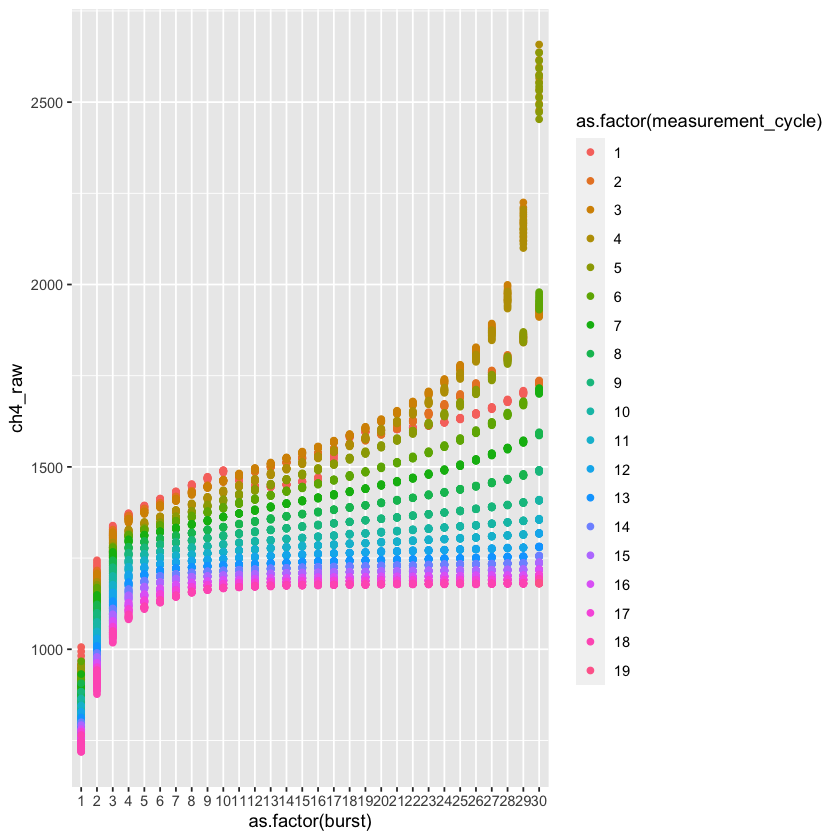

In [147]:
comp_parse<-parse_data(subset(comp_data,uuid=="57FF6A068387575136311367"),30,30)
comp_parse<-subset(comp_parse,measurement_cycle>0)


ggplot(comp_parse,aes(as.factor(burst),ch4_raw))+
geom_point(aes(color=as.factor(measurement_cycle)))

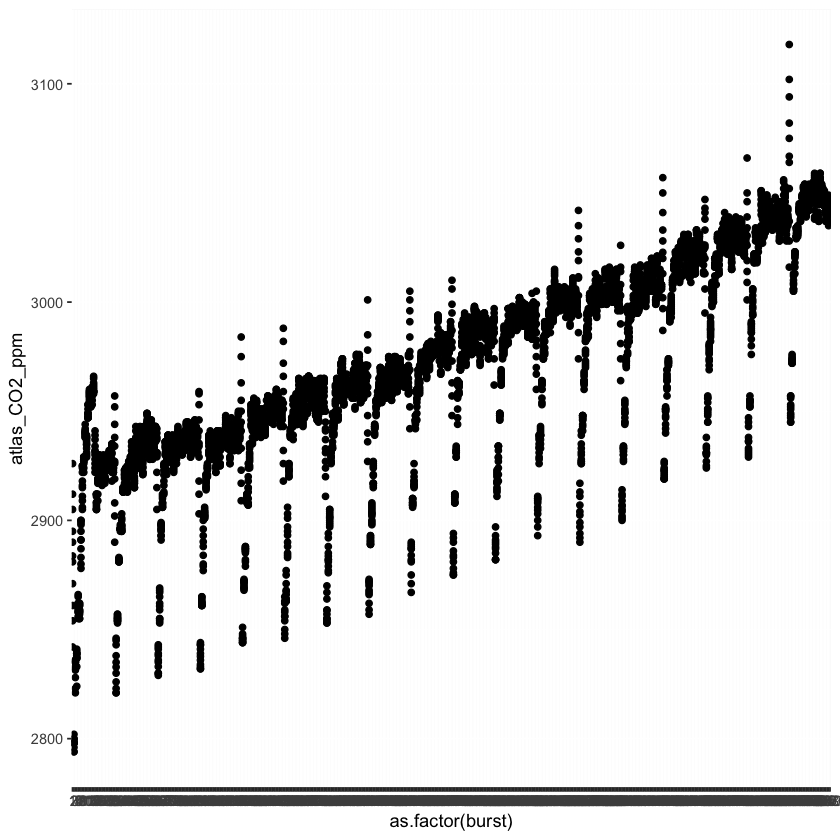

In [114]:
comp_parse<-parse_data(subset(comp_data,uuid=="50FF74068678545256252467"),30,30)
ggplot(comp_parse,aes(as.factor(burst),atlas_CO2_ppm))+
geom_point()

### Calculating rolling CV on a measurement cycle.

In [174]:
comp_parse<-parse_data(subset(comp_data,uuid=="57FF6A068387575136311367"),30,30)

comp_cv<-data.frame()

measurement_cycles<-unique(comp_parse$measurement_cycle)
measurement_cycles

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

In [177]:

for(i in 1:length(measurement_cycles)){
    comp_working<-subset(comp_parse,measurement_cycle==measurement_cycles[i])
    comp_working$roll_mean<-rollapply(data = comp_working$ch4_raw,width=4,align=c("right"),FUN=mean,fill=NA)
    comp_working$roll_sd<-rollapply(data = comp_working$ch4_raw,width=4,align=c("right"),FUN=sd,fill=NA)
    comp_working$roll_cv<-comp_working$roll_sd/comp_working$roll_mean
    comp_cv<-bind_rows(comp_cv,comp_working)
    }



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 60 rows containing missing values (geom_point).”


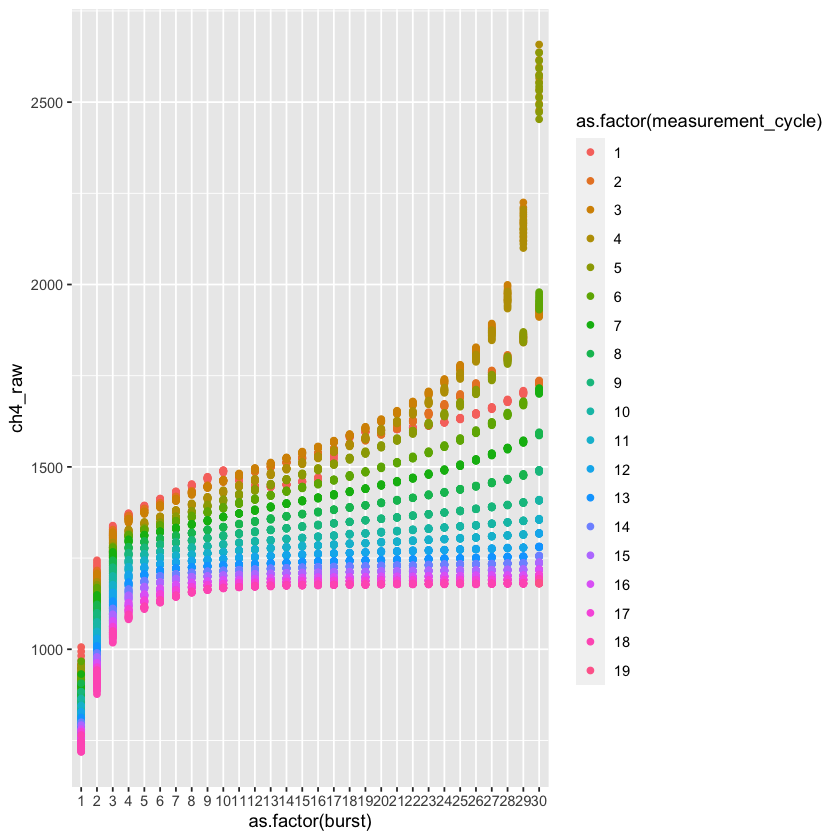

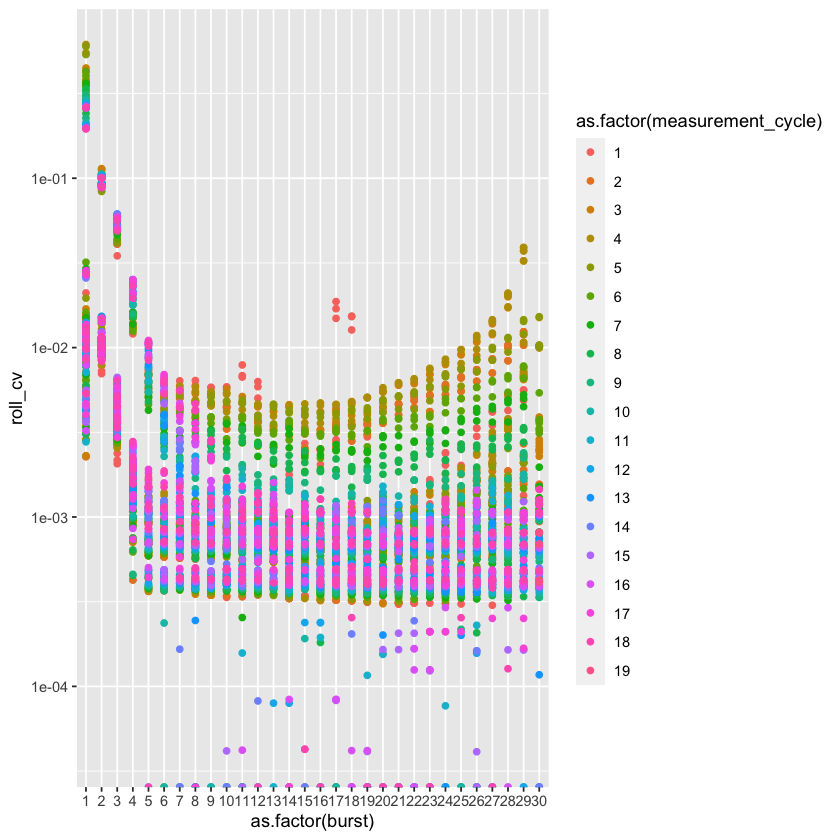

In [181]:

#comp_parse<-subset(comp_parse,measurement_cycle>0)


ggplot(comp_parse,aes(as.factor(burst),ch4_raw))+
geom_point(aes(color=as.factor(measurement_cycle)))


ggplot(comp_cv,aes(as.factor(burst),roll_cv))+
geom_point(aes(color=as.factor(measurement_cycle)))+
scale_y_log10()


In [59]:
comp_data_sum<-summaryBy(ch4_raw+ch4rf_raw~dtp+uuid,comp_parse,FUN=c(sd,mean))

In [61]:
head(comp_data_sum)
#comp_parse$dtp

,dtp,uuid,ch4_raw.sd,ch4rf_raw.sd,ch4_raw.mean,ch4rf_raw.mean
,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022-11-09 23:00:15,50FF6B068678545244122467,NA,NA,953,1996
2,2022-11-09 23:00:17,57FF6C068387575117330767,NA,NA,2119,4095
3,2022-11-09 23:00:17,50FF74068678545256252467,NA,NA,563,1984
4,2022-11-09 23:00:17,50FF6B068678545244122467,NA,NA,918,1995
5,2022-11-09 23:00:18,57FF6A068387575136311367,NA,NA,920,1951
6,2022-11-09 23:00:19,57FF6C068387575117330767,NA,NA,2057,4095


## Plotting average values per burst.

,dtp,uuid,ch4_raw.sd,ch4rf_raw.sd,ch4_raw.mean,ch4rf_raw.mean,ch4_raw_norm
,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022-11-09 23:00:15,50FF6B068678545244122467,NA,NA,953,1996,0.4774549
2,2022-11-09 23:00:17,57FF6C068387575117330767,NA,NA,2119,4095,0.5174603
3,2022-11-09 23:00:17,50FF74068678545256252467,NA,NA,563,1984,0.2837702
4,2022-11-09 23:00:17,50FF6B068678545244122467,NA,NA,918,1995,0.4601504
5,2022-11-09 23:00:18,57FF6A068387575136311367,NA,NA,920,1951,0.4715530
6,2022-11-09 23:00:19,57FF6C068387575117330767,NA,NA,2057,4095,0.5023199


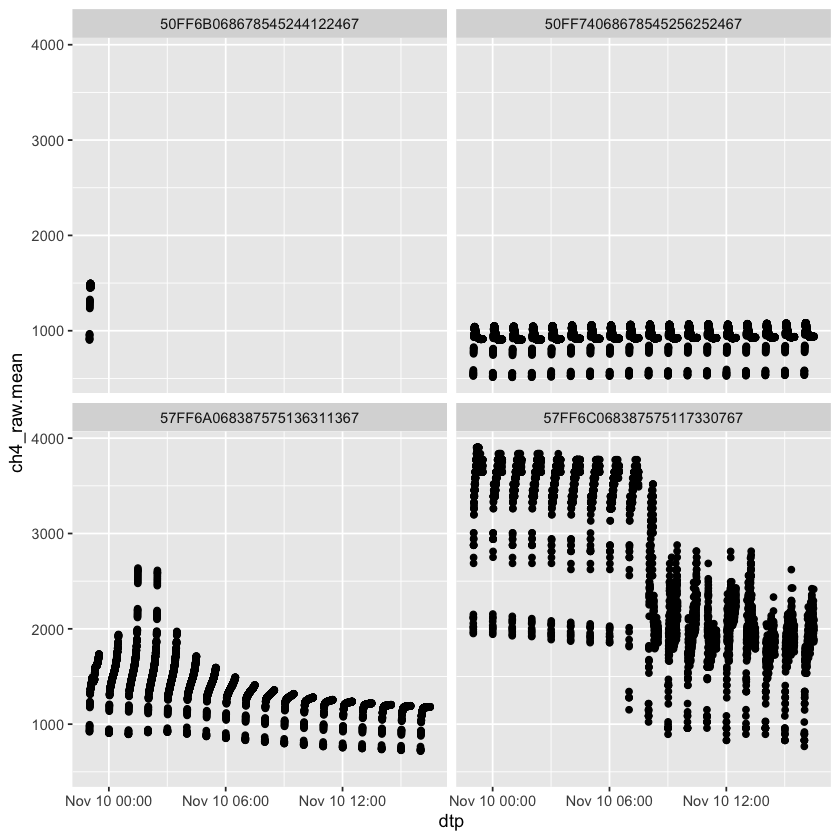

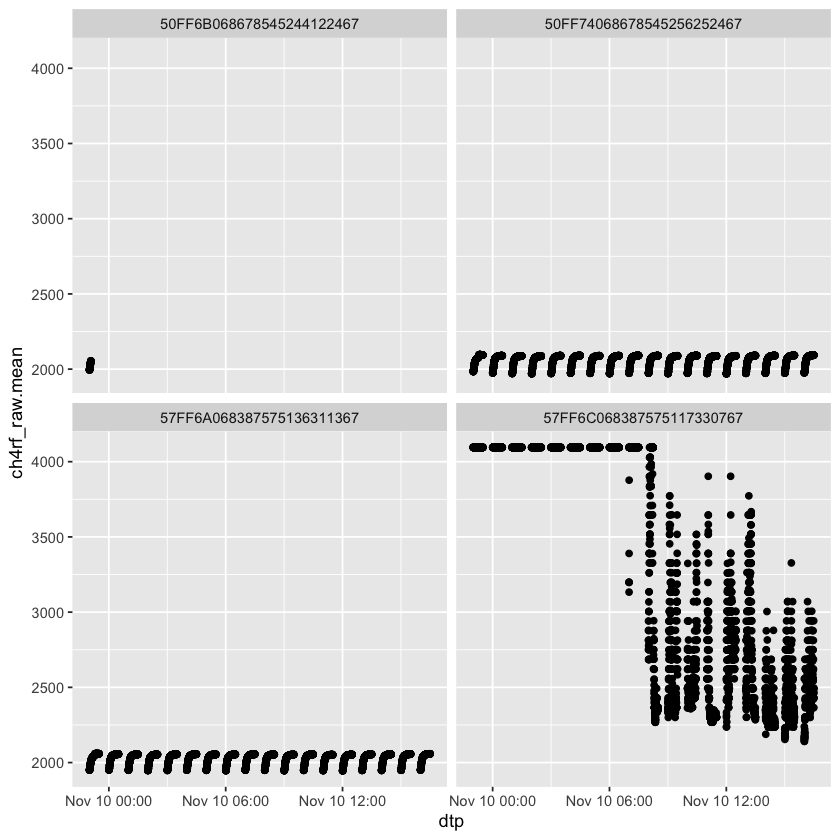

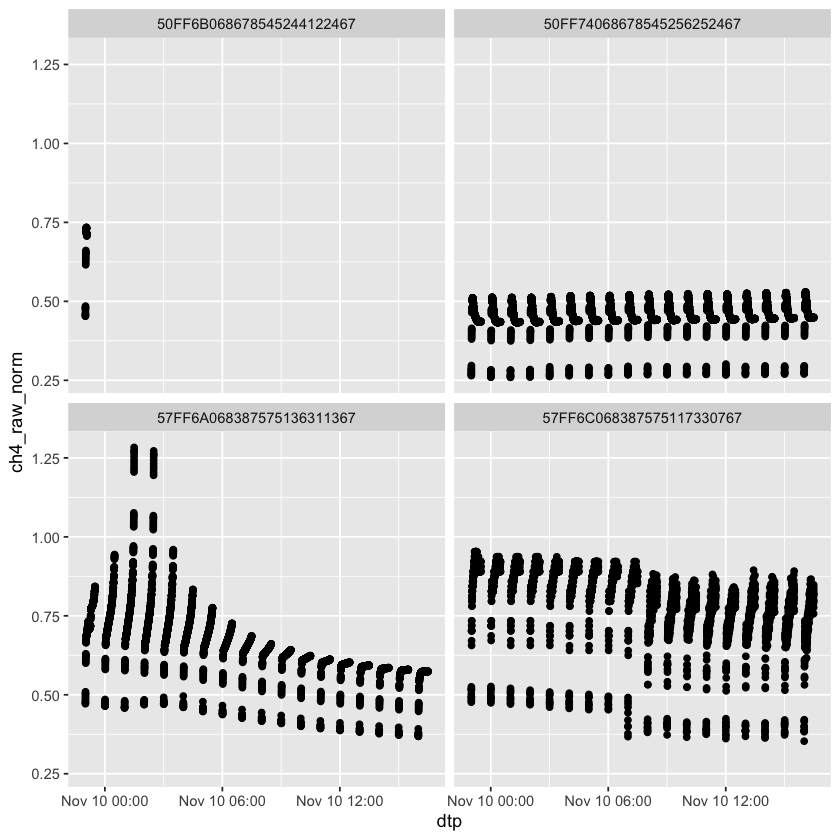

In [63]:
comp_data_sum$dtp<-as_datetime(comp_data_sum$dtp)

head(comp_data_sum)

ggplot(comp_data_sum,aes(dtp,ch4_raw.mean))+
geom_point()+
facet_wrap(.~uuid)


ggplot(comp_data_sum,aes(dtp,ch4rf_raw.mean))+
geom_point()+
facet_wrap(.~uuid)

comp_data_sum$ch4_raw_norm<-comp_data_sum$ch4_raw.mean/comp_data_sum$ch4rf_raw.mean

ggplot(comp_data_sum,aes(dtp,ch4_raw_norm))+
geom_point()+
facet_wrap(.~uuid)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


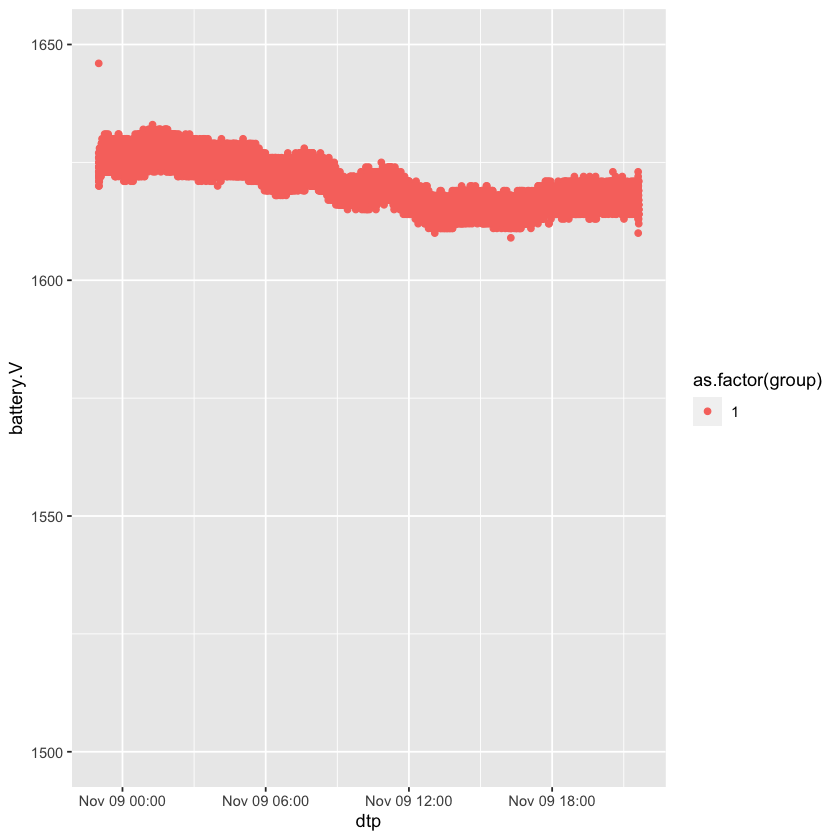

In [46]:
ggplot(subset(comp_data),aes(dtp,battery.V))+
    geom_point(aes(color=as.factor(group)))+
ylim(1500,1650)

In [27]:
names(comp_data)

[1] "type"          "site"          "logger"        "deployment"   
 [5] "deployed_at"   "uuid"          "time.s"        "time.h"       
 [9] "battery.V"     "dht_C"         "dht_RH"        "atlas_CO2_ppm"
[13] "ch4rf_raw"     "ch4rf_cal"     "ch4_raw"       "ch4_cal"      
[17] "user_note"     "user_value"    "time_epoch"    "dtp"          
[21] "interval"      "group"         "burstcount"

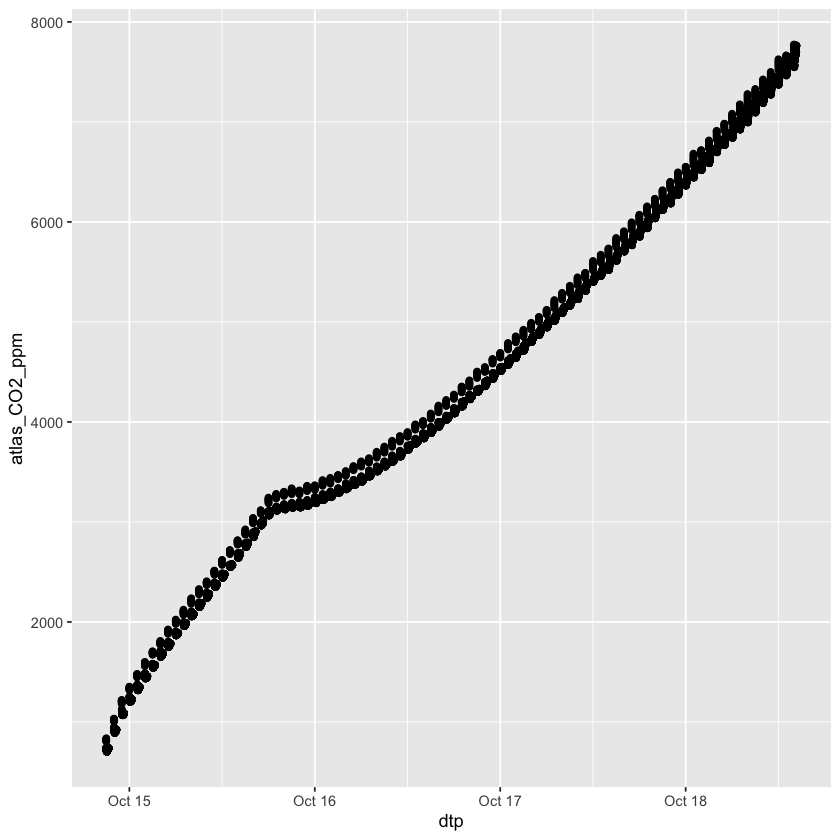

In [29]:
ggplot(comp_data,aes(dtp,atlas_CO2_ppm))+
       geom_point()

In [92]:
head(comp_data,n=100)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,dht_C,⋯,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,time_epoch,dtp,interval,group,burstcount
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<dttm>,<drtn>,<dbl>,<dbl>
1,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781215,2022-10-14 21:00:14.741,1790,22.0,⋯,0,1359,0,NA,NA,1665781214.741,2022-10-14 21:00:14,NA secs,1,1
2,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781217,2022-10-14 21:00:16.740,1646,22.0,⋯,0,1347,0,NA,NA,1665781216.74,2022-10-14 21:00:16,1.999 secs,1,1
3,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781219,2022-10-14 21:00:18.743,1621,22.0,⋯,0,1334,0,NA,NA,1665781218.743,2022-10-14 21:00:18,2.003 secs,1,2
4,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781221,2022-10-14 21:00:20.750,1615,21.7,⋯,0,1326,0,NA,NA,1665781220.75,2022-10-14 21:00:20,2.007 secs,1,3
5,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781223,2022-10-14 21:00:22.749,1630,21.7,⋯,0,1327,0,NA,NA,1665781222.749,2022-10-14 21:00:22,1.999 secs,1,4
6,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781225,2022-10-14 21:00:24.752,1631,21.7,⋯,0,1332,0,NA,NA,1665781224.752,2022-10-14 21:00:24,2.003 secs,1,5
7,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781227,2022-10-14 21:00:26.819,1632,21.7,⋯,0,1344,0,NA,NA,1665781226.819,2022-10-14 21:00:26,2.067 secs,1,6
8,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781229,2022-10-14 21:00:28.818,1627,21.7,⋯,0,1355,0,NA,NA,1665781228.818,2022-10-14 21:00:28,1.999 secs,1,7
9,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781231,2022-10-14 21:00:30.821,1627,21.7,⋯,0,1369,0,NA,NA,1665781230.821,2022-10-14 21:00:30,2.003 secs,1,8


In [81]:
head(comp_data,n=100)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,dht_C,⋯,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,time_epoch,dtp,interval,group
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<dttm>,<drtn>,<dbl>
1,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781215,2022-10-14 21:00:14.741,1790,22.00,⋯,2004.0,0,1359.0,0,NA,NA,1665781214.741,2022-10-14 21:00:14,NA secs,1
2,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781217,2022-10-14 21:00:16.740,1646,22.00,⋯,2005.0,0,1347.0,0,NA,NA,1665781216.74,2022-10-14 21:00:16,1.999000e+00 secs,1
3,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781219,2022-10-14 21:00:18.743,1621,22.00,⋯,2005.0,0,1334.0,0,NA,NA,1665781218.743,2022-10-14 21:00:18,2.003000e+00 secs,1
4,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781221,2022-10-14 21:00:20.750,1615,21.70,⋯,2003.0,0,1326.0,0,NA,NA,1665781220.75,2022-10-14 21:00:20,2.007000e+00 secs,1
5,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781223,2022-10-14 21:00:22.749,1630,21.70,⋯,2004.0,0,1327.0,0,NA,NA,1665781222.749,2022-10-14 21:00:22,1.999000e+00 secs,1
6,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781225,2022-10-14 21:00:24.752,1631,21.70,⋯,2005.0,0,1332.0,0,NA,NA,1665781224.752,2022-10-14 21:00:24,2.003000e+00 secs,1
7,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781227,2022-10-14 21:00:26.819,1632,21.70,⋯,2004.0,0,1344.0,0,NA,NA,1665781226.819,2022-10-14 21:00:26,2.067000e+00 secs,1
8,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781229,2022-10-14 21:00:28.818,1627,21.70,⋯,2004.0,0,1355.0,0,NA,NA,1665781228.818,2022-10-14 21:00:28,1.999000e+00 secs,1
9,raw,meso1,21003,mesoPilotTest-50FF6B068678545244122467-1665778141,1665778141,50FF6B068678545244122467,1665781231,2022-10-14 21:00:30.821,1627,21.70,⋯,2004.0,0,1369.0,0,NA,NA,1665781230.821,2022-10-14 21:00:30,2.003000e+00 secs,1
